In [257]:
from deepagri.data_pred import get_X_pred
from deepagri.data_prod import get_df_all
import requests
import tqdm

In [223]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import joblib

In [37]:
# Custom MAE that considers y_pred=0 if y_pred < 0, y_pred otherwise
def loss_mae_relu(y_true, y_pred):
    y_pred  = np.maximum(y_pred, 0)
    return np.mean(np.abs(y_true - y_pred))

mae_relu = make_scorer(loss_mae_relu, greater_is_better=True)

In [38]:
# Load yield data, surfaces estimations, 
df_rend = pd.read_csv('full_df_rendement.csv')
surfaces_2022 = pd.read_csv('surfaces2022.csv')
pred_2022 = get_X_pred()

/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/code/Constantier/deepagri/deepagri/meteo_agg.py:127: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  df_agg.loc[:, idx[:,cols_to_shift]] = (df_agg.loc[:, idx[:,cols_to_shift]]
/Users/constantintalandier/.pyenv/ve

In [39]:
# Baseline for yield: 
mean_absolute_error(df_rend.loc[93*5:, 'rendement'], df_rend.loc[93*5:, 'rendement_n-1'])

10.281318238419363

8.856837023894919


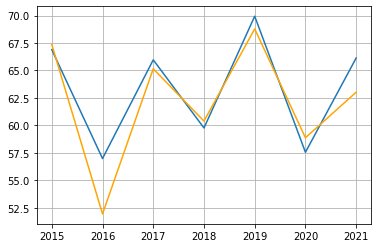

In [210]:
score = []
pred = []
reel = []

for ligne in range(93 * 5, df_rend.shape[0], 93):
    model = Pipeline([('Scaling', StandardScaler()),
        ('Linear', LinearRegression())])


    features = [
        'cluster_0',
        'cluster_1',
        'cluster_2',
        'cluster_3',
        'cluster_4',
 'windspeed_max 09_n-1','windspeed_max 11_n-1','tmin_c 10_n-1','tmax_c 01','dewmax_c 09_n-1','uv_idx 01',
 'uv_idx 03','tmin_deg 10_n-1','tmax_c 04','dewmax_c 11_n-1','snow_mm 03','tmax_deg 05','rain_mm 10_n-1',
        'rain_mm 11_n-1'
    ]

    X_train = df_rend.iloc[:ligne][features]
    y_train = df_rend.iloc[:ligne]['rendement']


    X_test = df_rend.iloc[ligne:ligne + 93][features]
    y_test = df_rend.iloc[ligne:ligne + 93]['rendement']

 
    model.fit(X_train, y_train)
    
    pred.append(model.predict(X_test))
    reel.append(y_test)
    score.append(loss_mae_relu(y_test, pred[-1]))

pred = np.array(pred)
reel = np.array(reel)
print(np.mean(score))
index_plot=list(range(2015,2022))
plt.plot(index_plot,pred.mean(axis=1))
plt.plot(index_plot,reel.mean(axis=1),c='orange')
plt.grid()

In [162]:
df_rend

,Unnamed: 0,Agriculteur,rendement,rendement_n-1,RatioSep,RatioOct,Prix_matos,tmax_c 01,tmax_c 02,tmax_c 03,...,tmin_deg 05,tmin_deg 09_n-1,tmin_deg 10_n-1,tmin_deg 11_n-1,tmin_deg 12_n-1,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
0,2010-1,2820.041792,71.964054,69.712601,1.229426,1.255319,92.741667,7.0,5.0,7.0,...,3.0,6.0,-3.0,2.0,-9.0,0,1,0,0,0
1,2010-2,3563.698886,83.685590,89.977942,1.229426,1.255319,92.741667,4.0,6.0,7.0,...,4.0,8.0,0.0,3.0,-8.0,0,0,0,0,1
2,2010-3,4276.654443,65.000000,68.000000,1.229426,1.255319,92.741667,6.0,5.0,9.0,...,2.0,7.0,-4.0,0.0,-7.0,0,1,0,0,0
3,2010-4,1462.803043,33.000000,35.000000,1.229426,1.255319,92.741667,3.0,6.0,6.0,...,3.0,6.0,-4.0,-2.0,-12.0,1,0,0,0,0
4,2010-5,1406.337173,41.000000,41.000000,1.229426,1.255319,92.741667,3.0,5.0,4.0,...,-1.0,-1.0,-11.0,-9.0,-21.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,2021-91,422.282609,81.000000,72.000000,1.104197,1.072703,89.891667,6.0,4.0,4.0,...,6.0,10.0,7.0,3.0,2.0,0,1,0,0,0
1112,2021-93,80.734902,83.000000,78.000000,1.104197,1.072703,89.891667,14.0,6.0,8.0,...,10.0,12.0,10.0,6.0,6.0,1,0,0,0,0
1113,2021-94,65.237675,81.000000,72.000000,1.104197,1.072703,89.891667,5.0,4.0,4.0,...,7.0,10.0,8.0,4.0,2.0,1,0,0,0,0
1114,2021-95,213.709486,83.000000,78.000000,1.104197,1.072703,89.891667,8.0,5.0,4.0,...,5.0,9.0,7.0,3.0,-1.0,0,1,0,0,0


In [121]:
list(df_rend.columns)

['Unnamed: 0',
 'Agriculteur',
 'rendement',
 'rendement_n-1',
 'RatioSep',
 'RatioOct',
 'Prix_matos',
 'tmax_c 01',
 'tmax_c 02',
 'tmax_c 03',
 'tmax_c 04',
 'tmax_c 05',
 'tmax_c 09_n-1',
 'tmax_c 10_n-1',
 'tmax_c 11_n-1',
 'tmax_c 12_n-1',
 'tmin_c 01',
 'tmin_c 02',
 'tmin_c 03',
 'tmin_c 04',
 'tmin_c 05',
 'tmin_c 09_n-1',
 'tmin_c 10_n-1',
 'tmin_c 11_n-1',
 'tmin_c 12_n-1',
 'windspeed_max 01',
 'windspeed_max 02',
 'windspeed_max 03',
 'windspeed_max 04',
 'windspeed_max 05',
 'windspeed_max 09_n-1',
 'windspeed_max 10_n-1',
 'windspeed_max 11_n-1',
 'windspeed_max 12_n-1',
 'rain_mm 01',
 'rain_mm 02',
 'rain_mm 03',
 'rain_mm 04',
 'rain_mm 05',
 'rain_mm 09_n-1',
 'rain_mm 10_n-1',
 'rain_mm 11_n-1',
 'rain_mm 12_n-1',
 'humidity_pct 01',
 'humidity_pct 02',
 'humidity_pct 03',
 'humidity_pct 04',
 'humidity_pct 05',
 'humidity_pct 09_n-1',
 'humidity_pct 10_n-1',
 'humidity_pct 11_n-1',
 'humidity_pct 12_n-1',
 'pressuremax_mb 01',
 'pressuremax_mb 02',
 'pressuremax_mb

In [211]:
# Create sample for 2022, rendement 2021 becomes rendement_n-1 feature for 2022
sample_2022 = df_rend.iloc[-93:][features].copy()
sample_2022.rename(columns={'rendement': 'rendement_n-1'}, inplace=True)

In [228]:
sample_2022.iloc[0]

cluster_0                 0.000000
cluster_1                 1.000000
cluster_2                 0.000000
cluster_3                 0.000000
cluster_4                 0.000000
windspeed_max 09_n-1      7.766667
windspeed_max 11_n-1      7.733333
tmin_c 10_n-1            27.000000
tmax_c 01                 6.000000
dewmax_c 09_n-1          18.000000
uv_idx 01                 1.451613
uv_idx 03                 2.645161
tmin_deg 10_n-1           2.000000
tmax_c 04                 6.000000
dewmax_c 11_n-1          12.000000
snow_mm 03                1.400000
tmax_deg 05              23.000000
rain_mm 10_n-1          273.500000
rain_mm 11_n-1           17.500000
Name: 1023, dtype: float64

In [92]:
# Drop 75, 92 and 96 for Paris, Hauts de Seine, France
for i in [74, 91, 95]:
    surfaces_2022.drop(i, axis=0, inplace=True)

KeyError: '[74] not found in axis'

In [221]:
# Predict on 2022 sample
pred = model.predict(sample_2022)

In [229]:
pred

array([72.70449712, 84.07940597, 70.60097204, 52.80510936, 50.33367111,
       56.23341641, 57.07059876, 70.78866387, 48.3633    , 79.87087275,
       48.08244329, 55.01115975, 54.44060827, 72.28643253, 61.20219013,
       61.91271535, 64.89864988, 68.73122635, 57.51278471, 71.21982835,
       67.33090339, 60.564372  , 52.46217861, 54.8409704 , 55.38647649,
       85.54023543, 85.2034703 , 63.00001491, 50.40836086, 64.40008907,
       66.49718965, 52.49371275, 55.40535709, 69.00802863, 69.41740964,
       69.94713173, 69.10300057, 59.36685319, 50.63970248, 68.65454855,
       57.07059876, 57.73727306, 62.47578145, 71.10654414, 54.31269529,
       64.77030606, 57.10711085, 67.69034136, 67.58481302, 85.47387727,
       68.68803949, 71.20126991, 73.80448972, 71.07706036, 67.34906525,
       72.76961491, 66.24864845, 82.46739771, 86.17918696, 70.4307137 ,
       84.73743149, 69.36002163, 46.88532902, 47.80617428, 45.36892271,
       74.66209255, 58.16988223, 60.36974855, 64.81293536, 67.98

In [222]:
# Multiply predicted yield with estimated surfaces to get national prediction for production
np.sum(pred * surfaces_2022['2022']) / 10**7

34.209319892056975

In [220]:
model = Pipeline([('Scaling', StandardScaler()),
        ('Linear', LinearRegression())])
features = [
        'cluster_0',
        'cluster_1',
        'cluster_2',
        'cluster_3',
        'cluster_4',
 'windspeed_max 09_n-1','windspeed_max 11_n-1','tmin_c 10_n-1','tmax_c 01','dewmax_c 09_n-1','uv_idx 01',
 'uv_idx 03','tmin_deg 10_n-1','tmax_c 04','dewmax_c 11_n-1','snow_mm 03','tmax_deg 05','rain_mm 10_n-1',
        'rain_mm 11_n-1'
    ]

X = df_rend[features]
y = df_rend['rendement']
model.fit(X,y)

Pipeline(steps=[('Scaling', StandardScaler()), ('Linear', LinearRegression())])

In [224]:
joblib.dump(model,'Model_DeepAgri.joblib')

['Model_DeepAgri.joblib']

In [252]:
def pred(Serie):
    url='http://127.0.0.1:8000/predict'
    params={
        'cluster_0':Serie['cluster_0'],
        'cluster_1':Serie['cluster_1'],
        'cluster_2':Serie['cluster_2'],
        'cluster_3':Serie['cluster_3'],
        'cluster_4':Serie['cluster_4'],
        'windspeed_max_09_n_1':Serie['windspeed_max 09_n-1'],
        'windspeed_max_11_n_1':Serie['windspeed_max 11_n-1'],
        'tmin_c_10_n_1':Serie['tmin_c 10_n-1'],
        'tmax_c_01':Serie['tmax_c 01'],
        'dewmax_c_09_n_1':Serie['dewmax_c 09_n-1'],
        'uv_idx_01':Serie['uv_idx 01'],
        'uv_idx_03':Serie['uv_idx 03'],
        'tmin_deg_10_n_1':Serie['tmin_deg 10_n-1'],
        'tmax_c_04':Serie['tmax_c 04'],
        'dewmax_c_11_n_1':Serie['dewmax_c 11_n-1'],
        'snow_mm_03':Serie['snow_mm 03'],
        'tmax_deg_05':Serie['tmax_deg 05'],
        'rain_mm_10_n_1':Serie['rain_mm 10_n-1'],
        'rain_mm_11_n_1':Serie['rain_mm 11_n-1']
    }
    resp=requests.get(url,params).json()
    print(resp)
    

In [258]:
sample_2022.apply(pred,axis=1)

for i in tqdm(range(len(sample_2022.index))):
    pred(sample_2022.iloc[i])

TypeError: 'module' object is not callable

In [256]:
sample_2022

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,windspeed_max 09_n-1,windspeed_max 11_n-1,tmin_c 10_n-1,tmax_c 01,dewmax_c 09_n-1,uv_idx 01,uv_idx 03,tmin_deg 10_n-1,tmax_c 04,dewmax_c 11_n-1,snow_mm 03,tmax_deg 05,rain_mm 10_n-1,rain_mm 11_n-1
1023,0,1,0,0,0,7.766667,7.733333,27.0,6.0,18.0,1.451613,2.645161,2.0,6.0,12.0,1.4,23.0,273.5,17.5
1024,0,0,0,0,1,16.233333,18.100000,24.0,7.0,17.0,1.548387,2.677419,5.0,4.0,16.0,0.0,21.0,165.1,40.1
1025,0,1,0,0,0,8.433333,7.466667,27.0,7.0,16.0,1.516129,2.451613,2.0,5.0,13.0,0.3,23.0,133.5,13.1
1026,1,0,0,0,0,10.166667,5.733333,26.0,6.0,16.0,1.580645,2.645161,-1.0,6.0,11.0,15.1,24.0,129.9,19.8
1027,1,0,0,0,0,7.900000,5.666667,24.0,9.0,14.0,1.580645,2.419355,-5.0,5.0,11.0,3.2,21.0,206.4,22.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,0,1,0,0,0,13.100000,14.433333,25.0,6.0,17.0,1.741935,3.000000,7.0,4.0,15.0,0.0,23.0,105.6,11.8
1112,1,0,0,0,0,19.400000,19.400000,52.0,14.0,20.0,2.838710,3.935484,10.0,14.0,15.0,0.0,23.0,129.8,40.6
1113,1,0,0,0,0,12.433333,13.566667,24.0,5.0,17.0,1.774194,3.096774,8.0,4.0,15.0,0.0,23.0,122.3,21.4
1114,0,1,0,0,0,13.766667,14.966667,27.0,8.0,17.0,1.645161,2.903226,7.0,4.0,15.0,0.0,22.0,130.2,22.1


# Calcul des prod années precédentes avec le model

In [215]:
df_surface=get_df_all(what='surface')

In [216]:
df_surface

,surface,surface_n-1
Ind,,
2000-1,27500.0,NaN
2000-2,184400.0,NaN
2000-3,47137.0,NaN
2000-4,2100.0,NaN
2000-5,2890.0,NaN
...,...,...
2021-92,0.0,0.0
2021-93,330.0,325.0
2021-94,430.0,285.0
